In [2]:
import CM_code.spurious_george as sp
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy
import importlib as imp
import DL_basis_code.shared_functions_setup as setup
import CM_code.tjp_helper as tjp_helper
import time

imp.reload(tjp_helper)
imp.reload(sp)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)


print('Lens bin: %g - %g'%(sp.zed.zl_min, sp.zed.zl_max))
print('Source bin: %g - %g'%(sp.zed.zs_min, sp.zed.zs_max))

Lens bin: 0.2 - 1.2
Source bin: 0.05 - 3.5


### Load in theta, boost, and F data

In [6]:
# B_min1, r_p = sp.get_boosts(year=1, out_file='boost_scratch')
B_min1 = np.load('generated_data/boost_y1_lowZ.npz')['B_min1']
r_p = np.load('generated_data/boost_y1_lowZ.npz')['rp'] # Mpc/h
F_theta = sp.get_F(zlmin=zlmin, zlmax=zlmax, theta_dependence=True)

In [59]:
# load in redshift data
_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', year=1)
z_s, dndz_s, *_ = sp.zed.get_dndz_phot(gtype='source', year=1)
z_l, dndz_l, *_ = sp.zed.get_dndz_phot(gtype='lens', year=1)

theta = sp.rp_to_arcmin(r_p, zleff)

print(theta)

[ 0.41244312  0.88858177  1.91439139  4.12443122  8.8858177  19.1439139
 41.24431221]


In [ ]:
ell = np.unique(np.geomspace(180/(theta[-1]/60.) - 10, 180/(theta[0]/60.)))

# # create sacc file to pass data to TJP
tjp_helper.create_xi_t_sacc(year=1)

# sleep to let sacc file properly save to drive
time.sleep(15)

# generate y1 cov matrices for specified rho values
rho = [0.1, 0.5, 0.9]
covs = tjp_helper.get_lsst_covariance(lmax=ell.max(), rho=rho, year=1, 
                                     out_file='cov_scratch')

In [8]:
print(F_theta)
print(B_min1)
print(r_p)

[0.00122591 0.00122591 0.00122591 0.00122591 0.00132057 0.00284507
 0.00612939]
[0.1026505  0.06232334 0.03318188 0.01593803 0.0087606  0.00547499
 0.00285638]
[ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]


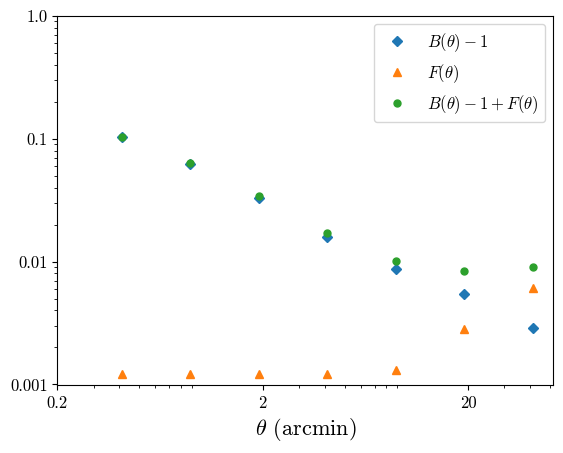

In [9]:
plt.plot(theta, B_min1, lw=0, marker='D', markersize=5)
plt.plot(theta, F_theta, lw=0, marker='^', markersize=6)
plt.plot(theta, B_min1+F_theta, lw=0, marker='o', markersize=5)
plt.xscale('log')
plt.yscale('log')
#plt.ylim([0.001, 6])
plt.yticks([0.001, 0.01, 0.1, 1.0],['0.001', '0.01', '0.1', '1.0'],
          fontsize=12)
plt.xticks([0.2, 2, 20], ['0.2', '2', '20'], fontsize=12)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=16)
plt.legend([r'$B(\theta) - 1$', r'$F(\theta)$', r'$B(\theta) - 1 + F(\theta)$'], fontsize=12)
plt.savefig('boost_and_f.png', bbox_inches='tight', dpi=300)

### Calculate maximum lensing residual

In [10]:
print(np.average(z_s, weights=dndz_s))

0.8818005812997556


In [60]:
# set ell values based on theta range
ell = np.unique(np.geomspace(180/(theta[-1]/60.) - 10, 
                             180/(theta[0]/60.) + 10, 
                             1024).astype(int))

# defined to be same as in boost function
k_arr = np.geomspace(1E-4, 5E4, 3000)

# create 2D power spectrum objects for galaxy-IA correlation
pk_gMf = sp.halo.get_Pk2D('gm', k_arr, np.linspace(0.1,1,32), year=1)

lensTracer = ccl.NumberCountsTracer(sp.zed.cosmo_SRD, has_rsd=False, dndz=(z_l, dndz_l), 
                                bias=(z_l, sp.lens_bias(z_l, year=1)))
shearTracer = ccl.WeakLensingTracer(sp.zed.cosmo_SRD, (z_s, dndz_s), 
                                     has_shear=True
                                    )

# compute angular power spectrum for galaxy-galaxy lensing using H.O.D.s
Cl_gM = ccl.angular_cl(sp.zed.cosmo_SRD, lensTracer, shearTracer, ell, p_of_k_a=pk_gMf)

# compute lensing shear
y_L = ccl.correlation(sp.halo.cosmo_SRD, ell, Cl_gM, theta / 60., type='NG')

In [61]:
# multiply by maximum residual bias and divide by P.A. fraction
# define multiplicative bias uncertainty
sigma_m = 0.013
delM_yL = (2.*sigma_m*y_L) / (B_min1 + F_theta)
yL = y_L / (B_min1 + F_theta)

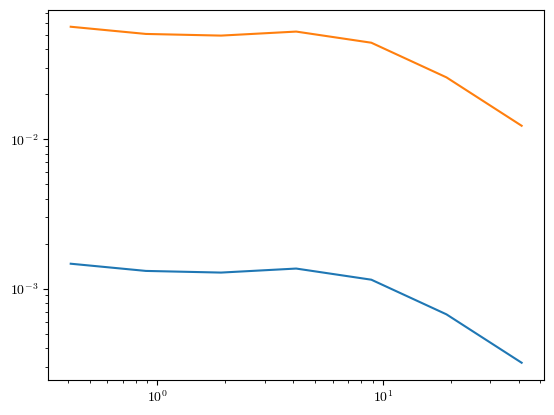

In [62]:
plt.loglog(theta, delM_yL, label='residual')
plt.loglog(theta, yL, label='lensing')

### Load in Y1 covariance matrix and combine with lensing residual 

In [70]:
#load in matrices and rho values
cov_file = np.load('generated_data/lsst_y1_covs_lowZ.npz')
rho = cov_file['rho']
covs = cov_file['covs']
print(np.shape(covs))
# add residual in quadrature to cov matrix
cov_IA = np.zeros_like(covs)
sigma_IA = np.zeros_like(covs[:,:,0])
for j in range(len(rho)):
    for i in range(len(theta)):
        for k in range(len(theta)):
            cov_IA[j,i,k] = (covs[j,i,k] / ((B_min1[i] + F_theta[i])*(B_min1[k] + F_theta[k]))) + delM_yL[i]*delM_yL[k]
    sigma_IA[j] = np.sqrt(np.diag(cov_IA[j,:,:]))
    
np.savez('generated_data/stat+sys_cov_lowZ', cov_IA=cov_IA, sigma_IA = sigma_IA)

(3, 7, 7)


In [71]:
# difference between sigma_IA for min and max rho values 
print(sigma_IA[0])

[0.00147014 0.00132052 0.00129665 0.0014051  0.00123326 0.00077549
 0.00041346]


In [72]:
y_IA = np.load('generated_data/Y1_IA_1h+NLA_lowZ.npz')['yIA']
bar_yIA = y_IA / (B_min1 + F_theta)

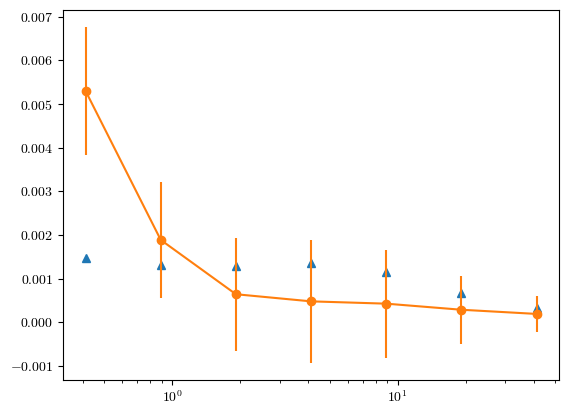

In [73]:
plt.plot(theta, delM_yL, lw=0, marker='^', label='residual')
#plt.plot(theta, yL, lw=0, marker='s', label='lensing')
plt.errorbar(theta, -bar_yIA, sigma_IA[0], marker='o', label='IA')
plt.xscale('log')
#plt.yscale('log')

In [ ]:
year=1
# find fraction of lens sample in chosen bin 
zl_full, dndzl_full, *_ = sp.zed.get_dndz_phot(gtype='lens', zlmin=0.05, zlmax=3.5, year=year, normalise=False)

zl, dndzl, *_ = sp.zed.get_dndz_phot(gtype='lens', zlmin=1.0, zlmax=1.2, year=year, normalise=False)

lens_tot = scipy.integrate.simps(dndzl_full, zl_full)
lens_bin = scipy.integrate.simps(dndzl, zl)

lens_frac = lens_bin/lens_tot
print('Fraction of lenses in bin: %g'%lens_frac)

# find fraction of source sample in chosen bin 
zs_full, dndzs_full, *_ = sp.zed.get_dndz_phot(gtype='source', zsmin=0.05, zsmax=3.5, year=year, normalise=False)

zs, dndzs, *_ = sp.zed.get_dndz_phot(gtype='source', zsmin=0.005, zsmax=1.2, year=year, normalise=False)

source_tot = scipy.integrate.simps(dndzs_full, zs_full)
source_bin = scipy.integrate.simps(dndzs, zs)

source_frac = source_bin/source_tot
print('Fraction of source in bin: %g'%source_frac)

In [88]:
zlmin, zlmax = 1.0, 1.2
zsmin, zsmax = 0.05, 3.5

B_min1, r_p = sp.get_boosts(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=1, out_file='boost_y1_zs=0.05-3.5')

_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=1)

rp = np.logspace(np.log10(sp.rpmin), np.log10(sp.rpmax), sp.N_bins)
theta = sp.rp_to_arcmin(rp, zleff)

lmax= 180/(theta[0]/60.)

tjp_helper.create_xi_t_sacc(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=1)

# sleep to let sacc file properly save to drive
time.sleep(15)

# generate y1 cov matrices for specified rho values
rho = [0.1, 0.5, 0.9]
covs = tjp_helper.get_lsst_covariance(zlmin=zlmin,zlmax=zlmax,
                                      zsmin=zsmin, zsmax=zsmax,
                                      lmax=lmax, rho=rho, year=1, 
                                     out_file='y1_covs_0.05-3.5')

Pk_gg calculated


100%|█████████████████████████████████████████| 300/300 [03:15<00:00,  1.53it/s]

xi_gg calculated


Order preserved for zl indices 0-299
xi_ls estimation complete
Finding boosts for 300 lens redshifts in range 1 - 1.2
Order preserved for zl indices 0-299
Boost estimation complete
Runtime = 4.29649 minutes
rp: [ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
th: [ 0.13995874  0.30153197  0.64963095  1.39958745  3.01531975  6.49630947
 13.99587447]
Fraction of lenses in bin: 0.111554
Fraction of source in bin: 1
Getting y1,y1 covariance...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Found covariance matrix for y1y1, getting y1,y2 for different rho...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.1
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.5
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.9


TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [90]:
zsmin, zsmax = 0.05, 2.4

B_min1, r_p = sp.get_boosts(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=1, out_file='boost_y1_zs=0.05-2.4')

_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=1)

rp = np.logspace(np.log10(sp.rpmin), np.log10(sp.rpmax), sp.N_bins)
theta = sp.rp_to_arcmin(rp, zleff)

lmax= 180/(theta[0]/60.)

tjp_helper.create_xi_t_sacc(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=1)

# sleep to let sacc file properly save to drive
time.sleep(15)

# generate y1 cov matrices for specified rho values
rho = [0.1, 0.5, 0.9]
covs = tjp_helper.get_lsst_covariance(zlmin=zlmin,zlmax=zlmax,
                                      zsmin=zsmin, zsmax=zsmax,
                                      lmax=lmax, rho=rho, year=1, 
                                     out_file='y1_covs_0.05-2.4')

Pk_gg calculated


100%|█████████████████████████████████████████| 300/300 [04:49<00:00,  1.04it/s]

xi_gg calculated


Order preserved for zl indices 0-299
xi_ls estimation complete
Finding boosts for 300 lens redshifts in range 1 - 1.2
Order preserved for zl indices 0-299
Boost estimation complete
Runtime = 6.25505 minutes
rp: [ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
th: [ 0.13995874  0.30153197  0.64963095  1.39958745  3.01531975  6.49630947
 13.99587447]
Fraction of lenses in bin: 0.111554
Fraction of source in bin: 0.99034
Getting y1,y1 covariance...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Found covariance matrix for y1y1, getting y1,y2 for different rho...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.1
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.5
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.9


TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [ ]:
zsmin, zsmax = 0.05, 1.2

B_min1, r_p = sp.get_boosts(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=1, out_file='boost_y1_zs=0.05-1.2')

_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=1)

rp = np.logspace(np.log10(sp.rpmin), np.log10(sp.rpmax), sp.N_bins)
theta = sp.rp_to_arcmin(rp, zleff)

lmax= 180/(theta[0]/60.)

tjp_helper.create_xi_t_sacc(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=1)

# sleep to let sacc file properly save to drive
time.sleep(15)

# generate y1 cov matrices for specified rho values
rho = [0.1, 0.5, 0.9]
covs = tjp_helper.get_lsst_covariance(zlmin=zlmin,zlmax=zlmax,
                                      zsmin=zsmin, zsmax=zsmax,
                                      lmax=lmax, rho=rho, year=1, 
                                     out_file='y1_covs_0.05-1.2')

Process ForkPoolWorker-8549:
Process ForkPoolWorker-8556:
Exception ignored in: <function _releaseLock at 0x7f890f85fc10>
Traceback (most recent call last):
  File "/nobackup/b7009348/miniconda3/envs/ccl_tjp/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process ForkPoolWorker-8546:
Process ForkPoolWorker-8552:
Process ForkPoolWorker-8558:
Process ForkPoolWorker-8551:
Process ForkPoolWorker-8557:
Process ForkPoolWorker-8542:
Process ForkPoolWorker-8548:
Process ForkPoolWorker-8550:
Process ForkPoolWorker-8547:
Process ForkPoolWorker-8545:
Process ForkPoolWorker-8554:
Process ForkPoolWorker-8553:
Process ForkPoolWorker-8541:
Process ForkPoolWorker-8544:
Process ForkPoolWorker-8555:
Process ForkPoolWorker-8543:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (m

### Dense rho values covariance 

In [3]:
zlmin, zlmax = 1.0, 1.2
zsmin, zsmax = 0.05, 3.5
_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=10)

rp = np.logspace(np.log10(sp.rpmin), np.log10(sp.rpmax), sp.N_bins)
theta = sp.rp_to_arcmin(rp, zleff)

lmax= 180/(theta[0]/60.)

tjp_helper.create_xi_t_sacc(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=10)

# sleep to let sacc file properly save to drive
time.sleep(15)

# generate y1 cov matrices for specified rho values
rho = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
covs = tjp_helper.get_lsst_covariance(zlmin=zlmin,zlmax=zlmax,
                                      zsmin=zsmin, zsmax=zsmax,
                                      lmax=lmax, rho=rho, year=10, 
                                     out_file='y10_covs_dense_0.05-3.5')

rp: [ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
th: [ 0.13995874  0.30153197  0.64963095  1.39958745  3.01531975  6.49630947
 13.99587447]
Fraction of lenses in bin: 0.116739
Fraction of source in bin: 1
Getting y1,y1 covariance...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Found covariance matrix for y1y1, getting y1,y2 for different rho...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.1
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.2
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.3
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.4
Computing independent co